# Toy Model

Trying toy model inspired by [Griffiths & Steyvers, 2004](https://doi.org/10.1073/pnas.0307752101).

In [141]:
from collections.abc import Sequence
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

from timeit import timeit

np.random.seed(42)
tf.random.set_seed(42)

In [142]:
from importlib import reload  

import topicflow.utils as tp_utils
import topicflow.data as tp_data

tp_utils = reload(tp_utils)
tp_data = reload(tp_data)


In [143]:
np.repeat([1, 2, 3], 2)

array([1, 1, 2, 2, 3, 3])

In [144]:
## One hot for numpy
def np_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

### **Sampling Behaviour of `tfp.Distributions`**

In [145]:
## tfd.Categorical sampling behaviour:
probs = tf.constant([[[0., 0., 1.], 
                      [1., 0., 0.]],
                     [[0., 1., 0.], 
                      [1., 0., 0.]]])
print(probs.shape)
print(tfd.Categorical(probs=probs).sample(4))

(2, 2, 3)
tf.Tensor(
[[[2 0]
  [1 0]]

 [[2 0]
  [1 0]]

 [[2 0]
  [1 0]]

 [[2 0]
  [1 0]]], shape=(4, 2, 2), dtype=int32)


In [146]:
## tfd.Dirichlet sampling behaviour:
conc = tf.constant([[0.1, 0.1, 0.1], 
                    [  2.,  2.,  2.]])
np.round(tfd.Dirichlet(concentration=conc).sample().numpy())

array([[0., 0., 1.],
       [0., 0., 0.]], dtype=float32)

$\rightarrow$ Samples come in by row. For Categorical the sample size is flexible. For Dirichlet the sample cise is bounded to the concentrations.

## **Setting up Topics and Data**

### Understand The indices in this Notebook

- $K$ is the number of topics 
- $D$ is the number of documents
- $I_d$ is the number of words in document $d$
- $N_{\mathrm{max}}$ is the maximum number of words per doument, i. e. $N_{\mathrm{max}} = \max_d \{I_d\}$
- $T$ is the total number of words, i. e. $T = \sum_d I_d$
- $V$ is the vocabulary size which should be a square of an integer for the visualization purposes of this notebook

### **1. Specify global parameters**

In [147]:
sqrtV   = 5       # Square Root of the Number of "Vocabulary" (must be sqrt such that pictorial interpretation is possible)
K       = 2*sqrtV # Number of Topics
D       = 1000    # Number of documents
N_fixed = 100     # Number of words per document
Alpha   = 1.      # Sparsity of Document-Topic matrix (higher is LESS sparse)

V = int(sqrtV**2)

### **2. Generating Data**

In [148]:
data = tp_data.squareLDDocuments(D, sqrtV, N_words_fixed=N_fixed)

In [149]:
Theta, Pi, C_DN, C_DNK, W_DN = data.extract_params()

In [150]:
C_DN

<tf.Tensor: shape=(1000, 100), dtype=int32, numpy=
array([[9, 2, 7, ..., 2, 7, 0],
       [7, 7, 8, ..., 7, 7, 5],
       [4, 9, 2, ..., 4, 4, 3],
       ...,
       [0, 8, 3, ..., 7, 4, 8],
       [3, 6, 6, ..., 2, 1, 2],
       [8, 7, 2, ..., 2, 7, 7]])>

In [151]:
test = tf.sparse.from_dense(C_DNK)
print(test)
print(tf.sparse.to_dense(test)[:2, :2, :10])

SparseTensor(indices=tf.Tensor(
[[  0   0   9]
 [  0   1   2]
 [  0   2   7]
 ...
 [999  97   2]
 [999  98   7]
 [999  99   7]], shape=(100000, 3), dtype=int64), values=tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(100000,), dtype=float32), dense_shape=tf.Tensor([1000  100   10], shape=(3,), dtype=int64))
tf.Tensor(
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]], shape=(2, 2, 10), dtype=float32)


In [152]:
test = tf.cast(test, dtype=tf.int32)
test.shape

TensorShape([1000, 100, 10])

In [153]:
Wp1 = W_DN + 1
W_stacked = tf.stack(K*[Wp1], axis=-1)  
W_stacked.shape

TensorShape([1000, 100, 10])

In [125]:
print("Topics for the Words in Document d=11:")
print(C_DN[11, :])
print("\nWords in Document d=11:")
print(W_DN[11, :])

Topics for the Words in Document d=11:
tf.Tensor(
[1 6 1 5 8 8 8 6 4 1 6 4 5 3 6 5 9 6 4 5 2 3 5 5 1 5 9 4 5 4 8 6 1 4 9 8 3
 5 5 8 3 5 8 5 6 5 3 9 1 9 4 6 6 8 9 5 4 6 4 3 5 9 6 7 9 8 5 2 4 4 7 9 9 4
 5 7 6 5 5 8 3 9 4 5 8 6 8 3 5 4 5 7 9 3 5 6 5 6 3 4], shape=(100,), dtype=int32)

Words in Document d=11:
tf.Tensor(
[ 5 11  5 15  3 18 23  1 23  7  6 23 10 19  1  5  4 21 20  5 12 19  0 15
  7  5  9 23  5 24 18 11  9 20 19 18 18 15 15 23 17  5 13 20 11 15 18  4
  5  9 24 21  1  3 24 15 20  1 24 17 10  4 16  7 19 23 15 12 24 23  7 19
  4 23 20  7 21  0 10 18 19 14 21 20  8 21  3 15 10 20 15 17  9 16 10 21
 15 21 16 22], shape=(100,), dtype=int32)


### **3. Checking Shapes**

In [126]:
## For development purposes:
def print_all_shapes():
    print("Π-Shape (D docs x K topics)")
    print(Pi.shape)
    print("\nΘ-Shape (K topic x V vocab)")
    print(Theta.shape)
    print("\nC_DN-Shape (Topic for each word T=sum_d I_d)")
    print(C_DN.shape)
    print("\nC_DNK-Shape (one-hot for each topic k in {1, K})")
    print(C_DNK.shape)
    print("\nW_DN-Shape (sum_d I_d words)")
    print(W_DN.shape)

In [127]:
print_all_shapes()

Π-Shape (D docs x K topics)
(1000, 10)

Θ-Shape (K topic x V vocab)
(10, 25)

C_DN-Shape (Topic for each word T=sum_d I_d)
(1000, 100)

C_DNK-Shape (one-hot for each topic k in {1, K})
(1000, 100, 10)

W_DN-Shape (sum_d I_d words)
(1000, 100)


## **Visualization**

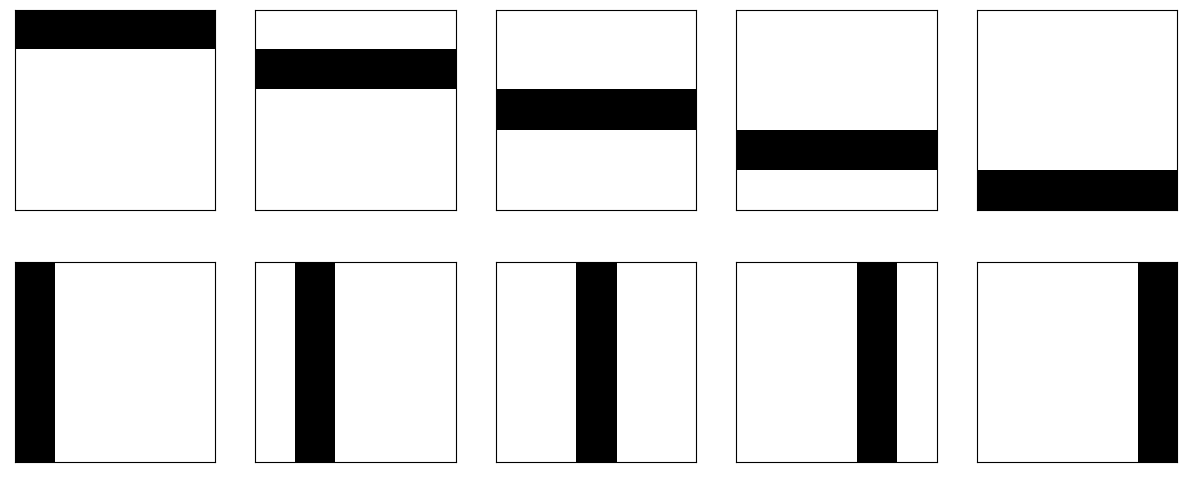

In [128]:
fig = tp_utils.visualize_topics(Theta, 2, 5)

Presenting documents [102 435 860 270 106  71 700  20 614 121]


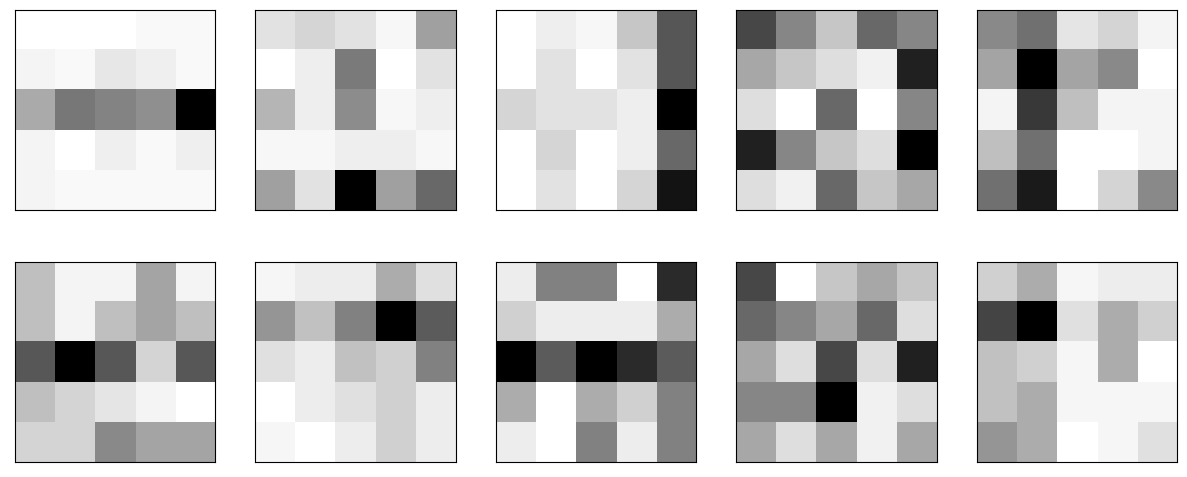

In [129]:
fig = tp_utils.visualize_random_docs(W_DN, 5)

## **Toy Document**

In [131]:
## Fixing single Pi
Pi0 = tf.constant([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

## Sampling single C
dist_C_N = tfd.Categorical(probs=Pi0)
C_N      = dist_C_N.sample(N_fixed)
C_0N     = tf.expand_dims(C_N, axis=0)
C_NK     = tf.one_hot(C_N, V, axis=-1)
C_0NK    = tf.expand_dims(C_NK, axis=0)

## Draw words for this single C
dist_W_0N = tfd.Categorical(probs=tf.gather(Theta, C_0N))
W_0N      = dist_W_0N.sample()

In [132]:
W_0N

<tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[17, 16, 19, 19, 17, 19, 19, 15, 19, 16, 15, 16, 19, 17, 18, 17,
        18, 19, 16, 16, 18, 19, 18, 19, 15, 16, 19, 19, 15, 18, 15, 16,
        18, 16, 19, 18, 19, 19, 18, 15, 19, 17, 17, 17, 15, 17, 17, 15,
        15, 15, 18, 15, 16, 19, 16, 18, 19, 16, 19, 16, 19, 18, 18, 19,
        17, 19, 17, 17, 17, 19, 17, 15, 18, 16, 16, 15, 19, 18, 18, 17,
        19, 19, 15, 16, 15, 17, 19, 15, 16, 19, 18, 15, 17, 19, 15, 15,
        18, 19, 16, 16]])>

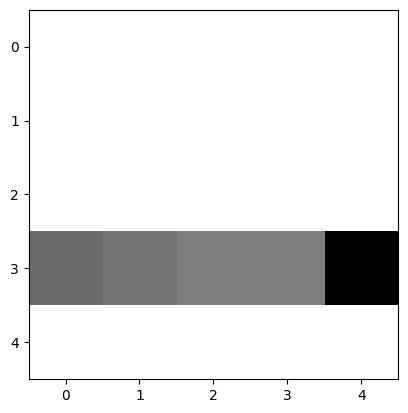

In [133]:
plt.imshow(tp_utils.doc_to_image(W_0N, sqrt_V=sqrtV), cmap="Greys")

## **Gibbs Sampler**

### **N-Tensor**
One efficiency crtitical step is to vectorize 
$$
    n_{dkv} =  \{i \, \vert \, w_{di} == v \ \& \ c_{idk} ==1\}
$$
as much as possible. Due to the fact, that the document lengths are variable there is the choice between looping over the number of documents or padding the documents to a unique length. The padding does not need a word-token, it can be done by padding the $C$ matrix with $0$, therefore it will not affect $N$. Then the counting can be realized by stacking $W$ $K$ times along the last axis to match the shape of $C$.

#### 1. Multiloop over all Dimensions

Mainly for test purposes. Horribly slow.

In [134]:
def multiloop_N_tensor(W_DN, C_DNK, V=V):

    ## Extracting shapes
    D = C_DNK.shape[0]
    N = C_DNK.shape[1]
    K = C_DNK.shape[2]

    ## To Numpy
    W_DN  = W_DN.numpy()
    C_DNK = C_DNK.numpy()
    N_DKV = np.zeros(shape=(D, K, V))
    
    for d in tqdm(range(D)):
        for k in range(K):
            for v in range(V):
                for i in range(N):
                    if W_DN[d, i] == v and C_DNK[d, i, k] == 1:
                        N_DKV[d, k, v] += 1

    return N_DKV

In [135]:
# N_test1 = multiloop_N_tensor(W_DN, C_DNK, V=V)

#### 2. Vectorized using `tf`

In [136]:
## Actual n-Tensor
@tf.function
def tf_N_tensor(W_DN, C_DNK, V=V):

    ## Extracting shapes
    D = C_DNK.shape[0]
    N = C_DNK.shape[1]
    K = C_DNK.shape[2]
    
    ## Preparing W-stacking by shifting all entries one "up" s. t. v is counted 
    #  from 1 to V+1 instead from 0 to V. This enables to collapse the "&" in the
    #  set to be collapsed to a matrix product
    Wp1 = W_DN + 1
    W_stacked = tf.stack(K*[Wp1], axis=-1)    

    ## Elementwise product combines logical & in condition.
    #  Choosing int32 as product dtype for efficiency.
    C_DNK_int = tf.cast(C_DNK, dtype=tf.int32)
    C_Dot_W = tf.math.multiply(W_stacked, C_DNK_int)

    ## The v-dimension of N is a one-hot encoding for the vocabulary:
    N_DNKVp1 = tf.one_hot(C_Dot_W, V+1, dtype=tf.int32)

    ## Reverting the v-shift by dropping the 0 one-hot dimension
    N_DNKV = N_DNKVp1[:, :, :, 1:]

    ## Summing along v-dimension
    assert N_DNKV.shape[1] == N
    N_DKV = tf.reduce_sum(N_DNKV, axis=1)

    ## Turn to float for gibbs sampler
    N_DKV = tf.cast(N_DKV, dtype=tf.float32)

    return N_DKV

In [137]:
N_test2 = tf_N_tensor(W_DN, C_DNK)

### **Sampling $C$**

Sampling $\Theta$ and $\Pi$ is not very problematic because they are just dirichlet distributed (below). Sampling $C$ is sampling from 
$$
    p(C\vert \Theta, \Pi, W)=\prod_{d=1}^D \prod_{i=1}^{N} \frac{\prod_{k=1}^K \left(\pi_{dk}\theta_{kw_{di}}\right)^{c_{dik}}}{\sum_{k'=1}^K\left(\pi_{dk'}\theta_{k'w_{di}}\right)}
$$ 
which is a categorical distribution. 

https://youtu.be/z2q7LhsnWNg?t=3878

In [563]:
## Vectorized C-Sampling
@tf.function
def sample_C(Theta, Pi, W_DN):
    ## Extracting shapes
    D = W_DN.shape[0]
    N = W_DN.shape[1]
    K = Pi.shape[-1]

    ## Numerator
    Theta_DKN = tf.gather(tf.transpose(Theta), W_DN) 
    Pi_block  = tf.stack(N * [Pi], axis=1)
    numerator = tf.math.multiply(Pi_block, Theta_DKN)

    ## Dividing by Denominator
    denominator = tf.reduce_sum(numerator, axis=-1)

    ## Sampling
    C_DN_dist = tfd.Categorical(probs=numerator)
    C_DN      = C_DN_dist.sample()

    ## One-Hot-Encoding
    C_DNK = tf.one_hot(C_DN, K, axis=-1)

    return C_DNK

In [564]:
## Test purposes
# Theta_DNK_loop = np.zeros(shape=(D, N, K))
# for d in tqdm(range(D)):
#     for i in range(N):
#         for k in range(K):
#             Theta_DNK_loop[d, i, k] = Theta[k, W_DN[d, i]]


In [565]:
## Test purposes
# numerator_test = np.zeros(shape=(D, N, K))
# for d in tqdm(range(D)):
#     for i in range(N):
#         for k in range(K):
#             numerator_test[d, i, k] = Pi[d, k]*Theta[k, W_DN[d, i]]

In [566]:
sample_C(Theta, Pi, W_DN)

<tf.Tensor: shape=(1000, 100, 10), dtype=float32, numpy=
array([[[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]],

       [[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0

### **Sampling $\Theta$ and $\Pi$**

Sampling $\Theta$ and $\Pi$:
$$
    \begin{align*}
        p(\Theta\vert C, W) &= \prod_{k=1}^K \mathcal D(\theta_k; \ \beta_{k:} + n_{\cdot k:}) \\
        p(\Pi\vert C, W)    &= \prod_{d=1}^D \mathcal D(\pi_d; \ \alpha_{d:} + n_{d:\cdot}) \, .
    \end{align*}
$$
$\Theta$ and $\Pi$ are neither dependent on the number of words per document nor do they have an $I_d$ dimension. Therefore it is much easier to sample them:

In [567]:
## tfd.Dirichlet sampling behaviour:
conc = tf.constant([[0.1, 0.1, 0.1], 
                    [  2.,  2.,  2.]])
np.round(tfd.Dirichlet(concentration=conc).sample().numpy(), 1)

array([[0. , 1. , 0. ],
       [0.1, 0.5, 0.4]], dtype=float32)

In [568]:
@tf.function
def sample_Theta(N_DKV, beta):
    conc = beta + tf.reduce_sum(N_DKV, axis=0)
    dist_Theta = tfd.Dirichlet(concentration=conc)
    Theta      = dist_Theta.sample()
    return Theta

@tf.function
def sample_Pi(N_DKV, alpha):
    conc = alpha + tf.reduce_sum(N_DKV, axis=-1)
    dist_Pi = tfd.Dirichlet(concentration=conc)
    Pi      = dist_Pi.sample()
    return Pi

In [569]:
## Random Initialization of Prior Alpha and Beta.
#  They do not acutally matter much but could be optimized by Type II MAP or MLE.
beta  = tf.constant(np.random.normal(size=(K, V)), dtype=tf.float32)
alpha = tf.constant(np.random.normal(size=(D, K)), dtype=tf.float32)

## Calculate one N_DKV for test purposes
N_test = tf_N_tensor(W_DN, C_DNK)

In [570]:
test_Theta = sample_Theta(N_test, beta)
test_Pi    = sample_Pi(N_test, alpha)

assert test_Theta.shape == Theta.shape
assert test_Pi.shape == Pi.shape

### **Main Loop**

In [571]:
N_iter = 300

C_DN_  = tf.constant(np.random.randint(0, 10, size=W_DN.shape))
C_DNK_ = tf.one_hot(C_DN_, K, axis=-1)

beta  = tf.ones(shape=(K, V), dtype=tf.float32)
alpha = tf.ones(shape=(D, K), dtype=tf.float32)

Note that `W_DN` and `N` are fixed since they are observable from the data and do therefore not have to be initialized.

In [572]:
Theta_store = []

for iter in tqdm(range(N_iter)):

    ## Calculate N_DKV_ from W_DN and C_DNK_
    N_DKV_ = tf_N_tensor(W_DN, C_DNK_)
    
    ## Sample Theta_ and Pi_ from N_DKV_ and priors
    Theta_ = sample_Theta(N_DKV_, beta)
    Pi_    = sample_Pi(N_DKV_, alpha)

    ## Sample next C_DNK_ from Theta, Pi
    C_DNK_ = sample_C(Theta_, Pi_, W_DN)

    Theta_store.append(Theta_)

100%|██████████| 300/300 [00:11<00:00, 25.03it/s]


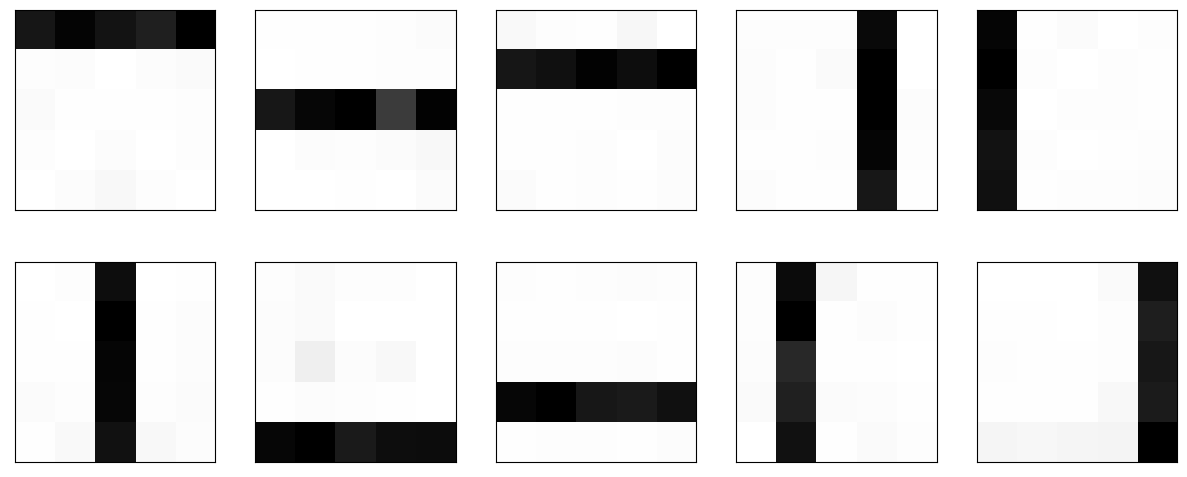

In [573]:
fig = tp_utils.visualize_topics(tf.reduce_mean(tf.stack(Theta_store[150:], axis=-1), axis=-1), 2, 5)

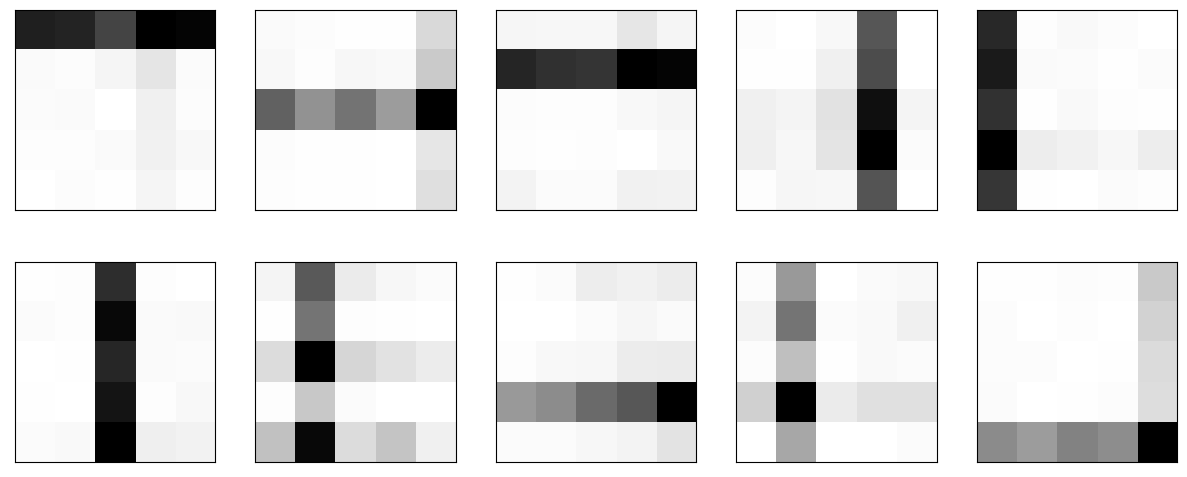

In [574]:
fig = tp_utils.visualize_topics(Theta_store[50], 2, 5)

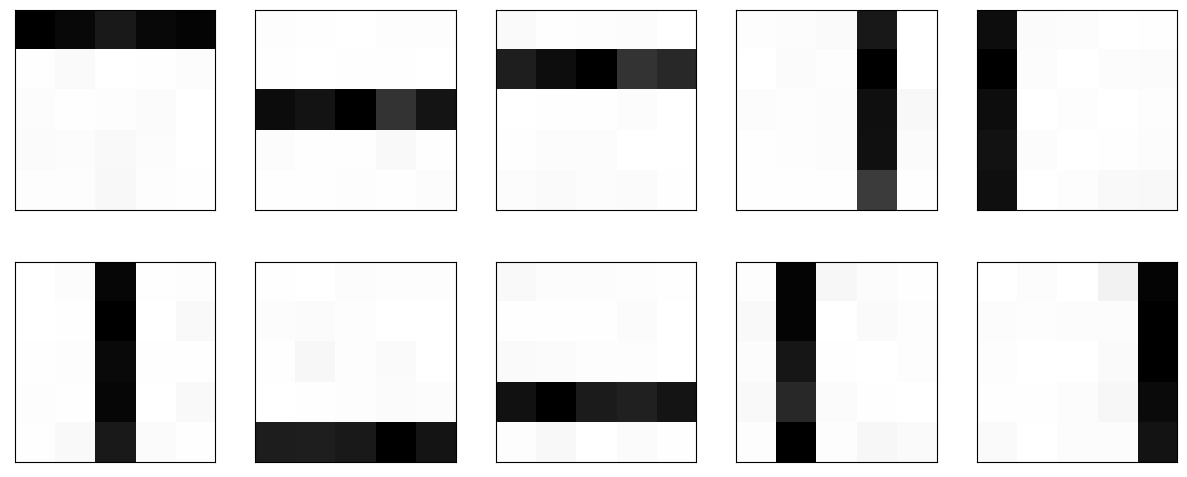

In [575]:
fig = tp_utils.visualize_topics(Theta_, 2, 5)